In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
import treegp
# %matplotlib widget

In [2]:
dic = pickle.load(open("out_test_0", "rb"))
dic2 = pickle.load(open("out_test_1", "rb"))

In [3]:
A = dic['in']['maskedImage']

In [4]:
dic2['in']['fwhm']

1.0

(-0.5, 2047.5, 4175.5, -0.5)

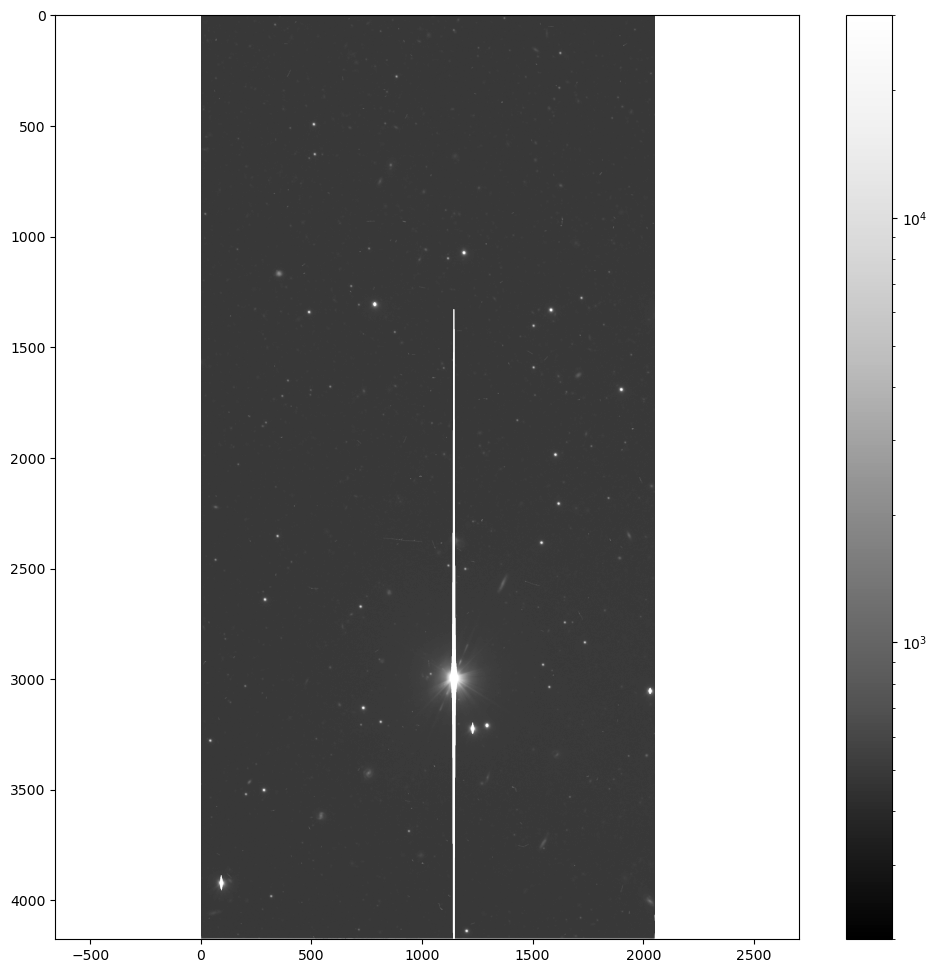

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(A.getImage().array,  norm=LogNorm(vmin=200, vmax=30000), cmap=plt.cm.Greys_r)
plt.colorbar()
plt.axis('equal')

In [6]:
B = dic['out']['maskedImage']

(-0.5, 2047.5, 4175.5, -0.5)

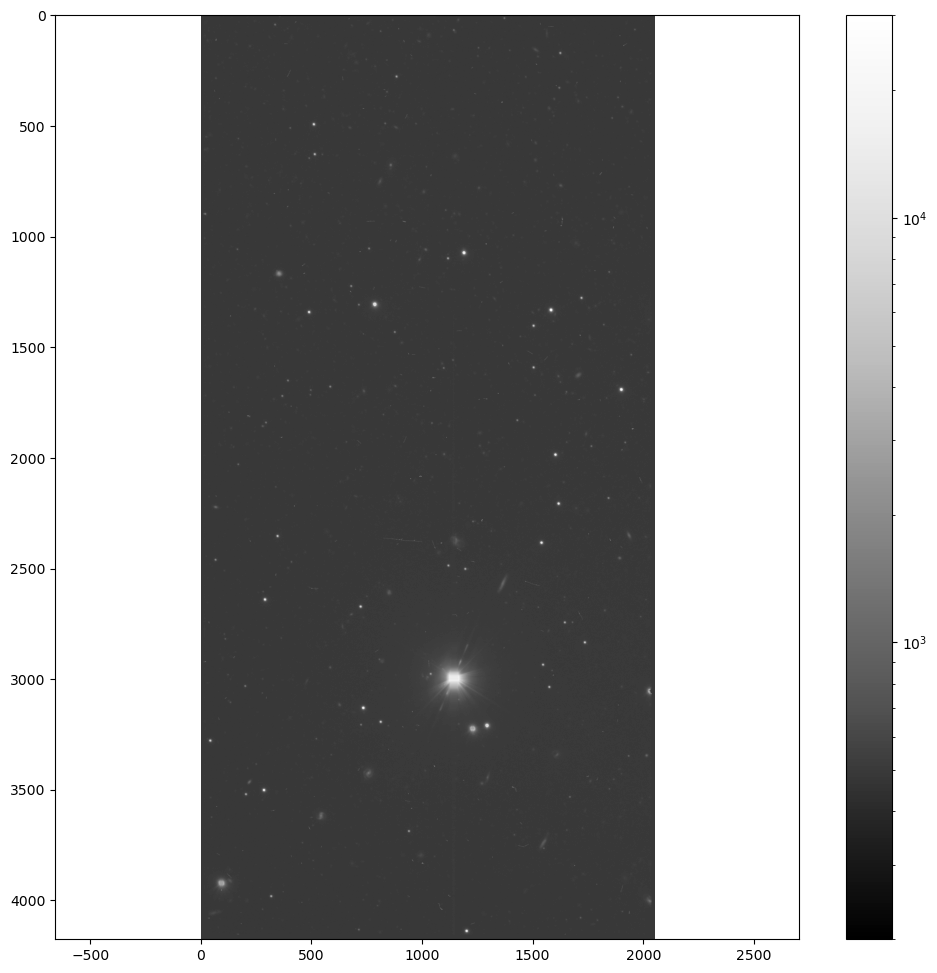

In [7]:
plt.figure(figsize=(12,12))
plt.imshow(B.getImage().array,  norm=LogNorm(vmin=200, vmax=30000), cmap=plt.cm.Greys_r)
plt.colorbar()
plt.axis('equal')

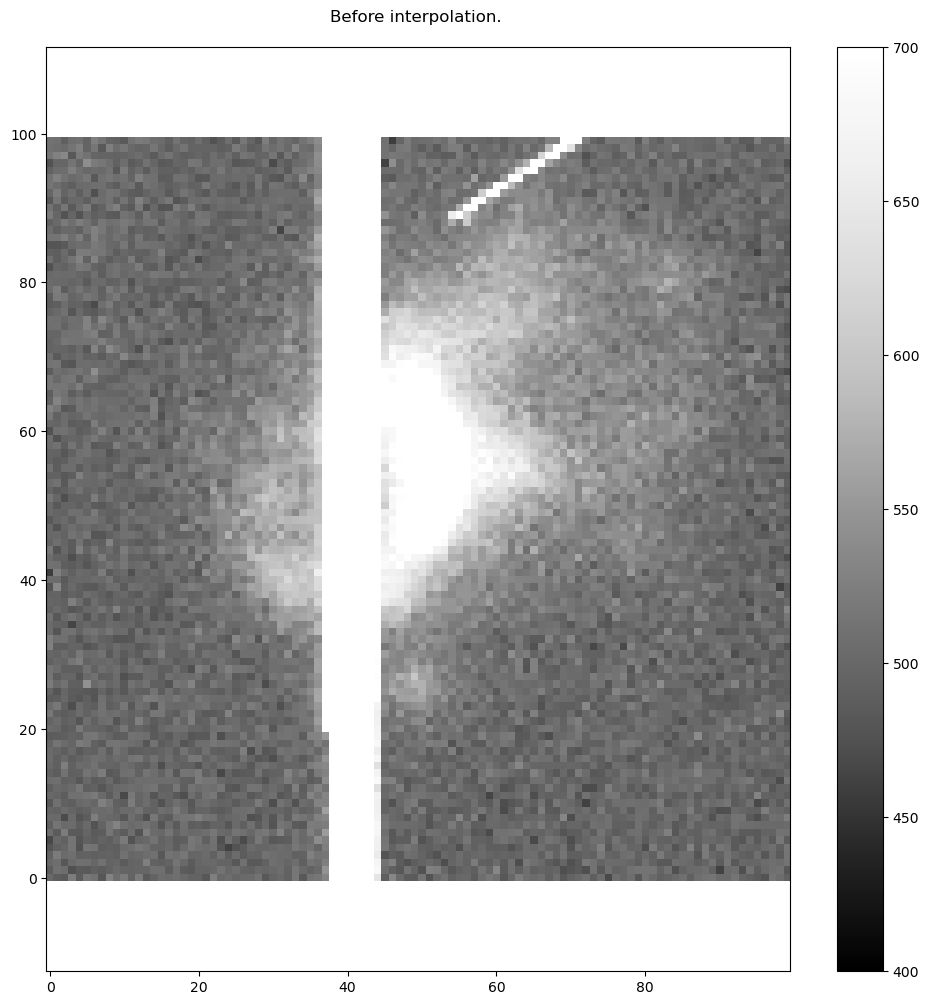

In [11]:
plt.figure(figsize=(12,12))
plt.title('Before interpolation. \n ')
plt.imshow(A.getImage().array[2320:2420, 1100:1200],  vmin=400, vmax=700, cmap=plt.cm.Greys_r)
plt.colorbar()
plt.gca().invert_yaxis()
plt.axis('equal')
plt.savefig('1_interp_test_0.png')

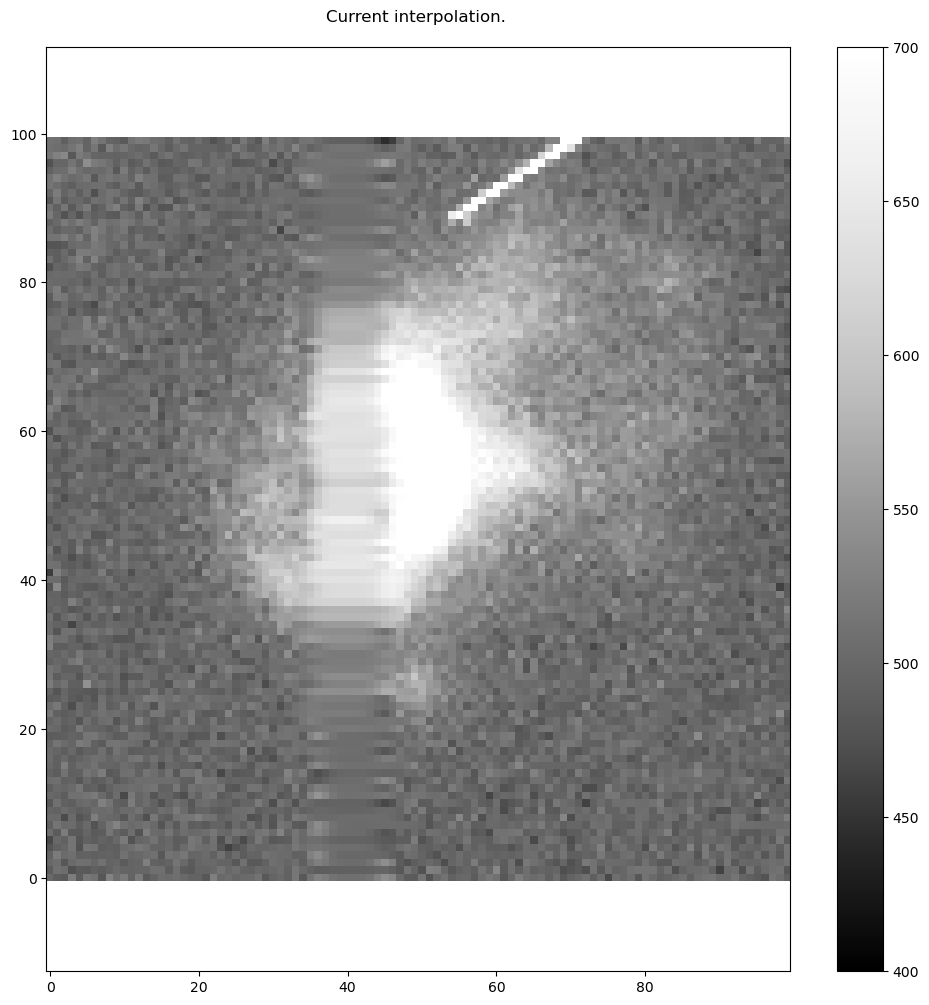

In [12]:
plt.figure(figsize=(12,12))
plt.title('Current interpolation. \n ')
plt.imshow(B.getImage().array[2320:2420, 1100:1200], vmin=400, vmax=700, cmap=plt.cm.Greys_r)
plt.colorbar()
plt.axis('equal')
plt.gca().invert_yaxis()
plt.savefig('1_interp_test_1.png')

In [13]:
data = A.getImage().array[2320:2420, 1100:1200]
data_var = A.getVariance().array[2320:2420, 1100:1200]
x = np.arange(data.shape[0])  # Columns represent the x-axis
y = np.arange(data.shape[1])  # Rows represent the y-axis
X, Y = np.meshgrid(x, y)  # Create the mesh grid
X = X.reshape(-1)
Y = Y.reshape(-1)
Coords = np.array(([X, Y])).T

In [14]:
mask = A.getMask().array
mask_cropped = mask[2320:2420, 1100:1200]
Filter = mask_cropped.reshape(-1) < 1

data_train = data.reshape(-1)[Filter]
var_train = data_var.reshape(-1)[Filter]
Coords_train = Coords[Filter]
Coords_val = Coords[~Filter]

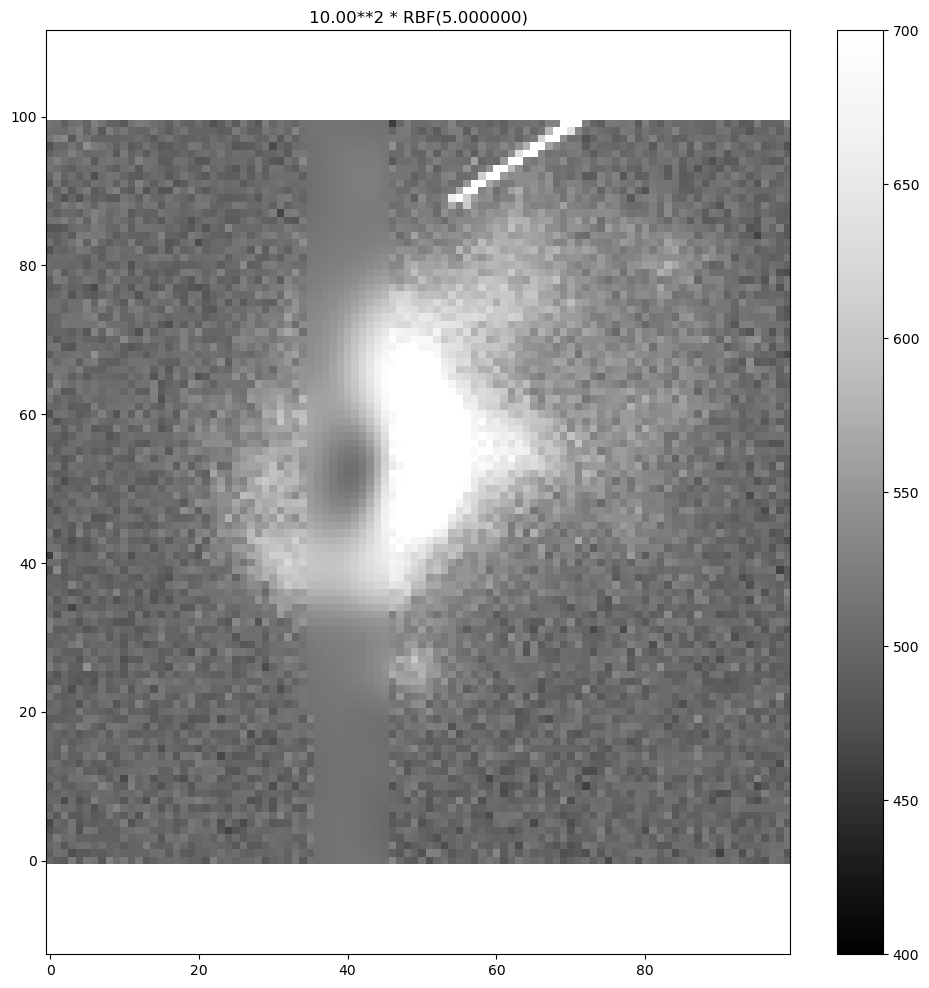

In [19]:
std = np.sqrt(np.var(data_train) - np.mean(var_train))

#for i in range(40):
#print(i)
i = 9
std = 10
KERNEL = '%.2f**2 * RBF(%f)'%((std, (i+1) / 2.))
    
gp = treegp.GPInterpolation(
    kernel=KERNEL,
    optimizer='none',
    normalize=True,
    p0=[3000.0, 0.0, 0.0],
    white_noise=np.mean(np.sqrt(var_train)),
    n_neighbors=4,
    average_fits=None,
    indice_meanify=None,
    nbins=20,
    min_sep=None,
    max_sep=None,
)
gp.initialize(Coords_train, data_train)
gp.solve()
data_val = gp.predict(Coords_val)


gp_interp = np.zeros_like(data.reshape(-1))
gp_interp[Filter] = data_train
gp_interp[~Filter] = data_val
gp_interp = gp_interp.reshape(np.shape(data))

plt.figure(figsize=(12,12))
plt.title(KERNEL)
plt.imshow(gp_interp, vmin=400, vmax=700, cmap=plt.cm.Greys_r)
plt.colorbar()
plt.axis('equal')
plt.gca().invert_yaxis()
plt.savefig('1_interp_test_2.png')
#plt.savefig('%i_rbf_gp_interp.png'%(i+1))
#plt.close()